In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objects as go
import datetime
from scipy import stats
import numpy as np
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
base_dir = Path.cwd()
path = str(base_dir / 'output_data')
anthro_path = str(base_dir / 'anthro_data')


In [47]:
# Helper plotting functions
def scatter_ax(ax, x, y, xlabel, title):
    ax.scatter(x, y, alpha=0.6)
    X = sm.add_constant(np.asarray(x,float))
    display(sm.OLS(np.asarray(y,float), X).fit().summary())
    beta = sm.OLS(np.asarray(y,float), X).fit().params
    xx = np.linspace(min(x), max(x), 100)
    yy = beta[0] + beta[1]*xx
    ax.plot(xx, yy, "--", color="black", linewidth=1.2, alpha=0.8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Discomfort increase per hour (slope)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

In [48]:
df_ratings_all = pd.read_csv(Path(path) / 'df_ratings_all.csv')
df_ratings_all.slope_hour = df_ratings_all.slope_hour / 10
df_ratings_all[:2]


,rating1,rating2,rating3,rating4,rating5,rating6,rating7,rating8,rating9,rating10,...,intercept,r-square,rmse,Significant,ll,ul,slope_hour,slope_direction,max_rating,slope_group
0,10.0,10.0,10.0,10.0,11.0,11.0,11.0,10.0,12.0,12.0,...,8.752,0.75784,1.39106,True,0.0159,0.0281,0.132,P,20.0,Below_3.1hrs
1,10.0,10.0,10.0,10.0,10.0,10.0,12.0,10.0,12.0,13.0,...,9.515,0.74473,0.97788,True,0.0107,0.0193,0.090,P,16.0,Below_3.1hrs


In [49]:
df_ratings_all.slope_hour.describe()

count    208.000000
mean       0.177577
std        0.207520
min       -0.372000
25%        0.024000
50%        0.102000
75%        0.282000
max        0.936000
Name: slope_hour, dtype: float64

In [50]:
df_ratings_all[['slope_hour' , 'Seat_angle']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   slope_hour  208 non-null    float64
 1   Seat_angle  208 non-null    object 
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [51]:
df_ratings_all.Seat_angle.isna().sum()

np.int64(0)

In [52]:
null_vals = ['', 'nan', 'N/A', None, 'na', 'None', 'none']
replaced_null = { item: np.nan for item in null_vals }
df_ratings_all['Seat_angle'].replace(replaced_null, inplace=True)
df_ratings_all.Seat_angle.isna().sum()

np.int64(0)

### Fix seat angles - 174 participants

<class 'pandas.core.series.Series'>
Index: 174 entries, 0 to 207
Series name: Seat_angle
Non-Null Count  Dtype 
--------------  ----- 
174 non-null    object
dtypes: object(1)
memory usage: 2.7+ KB


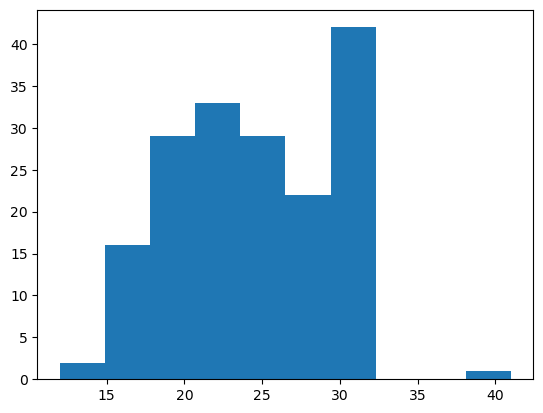

In [53]:
temp = df_ratings_all[~df_ratings_all['Seat_angle'].str.contains('[- ,]')]
temp.Seat_angle.info()
temp.Seat_angle = temp.Seat_angle.astype(float)
plt.hist(temp.Seat_angle);
fig = px.box(temp,  y= 'Seat_angle', notched = True,  )
             #color = 'Weight_status')
# Setting boxmean="sd" displays both the mean (dashed line) and standard deviation (filled area)
fig.update_traces(
    marker_line_color="black", # Sets the color of the lines bounding the box
    boxmean="sd",              # Sets the mean marker to a standard deviation shape
    selector=dict(type='box')
)

fig.update_layout(width=300, height=500, yaxis_title = 'Seat angle for 174 subjects')
fig.show();

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.903
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0902
Time:                        13:57:54   Log-Likelihood:                 26.322
No. Observations:                 174   AIC:                            -48.64
Df Residuals:                     172   BIC:                            -42.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0533      0.074      0.721      0.472      -0.093       0.199
x1             0.0050      0.003      1.704      0.090      -0.001       0.011
==============================================================================
Omnibus:                       36.600   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.317
Skew:                           1.183   Prob(JB):                     2.64e-12
Kurtosis:                       4.326   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

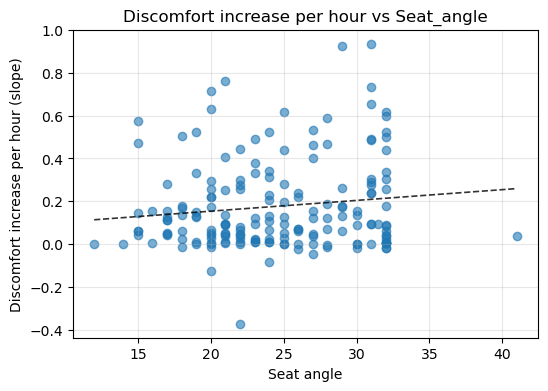

In [54]:
# Create combined figure
fig, axes = plt.subplots(figsize=(6,4))
scatter_ax(axes, temp["Seat_angle"], temp["slope_hour"], "Seat angle", "Discomfort increase per hour vs Seat_angle")
######### Seat angle is not significant (p-value=0.090) at 5% but not at 1% significance level

### All Seat angles - 208 participants (seat angles imputed using mean for each subject using its range of seat angle during study)

In [55]:
######### Sample of seat angles when it was not fixed ##########
df_ratings_all[df_ratings_all['Seat_angle'].str.contains('[- ,]')]['Seat_angle'][:3]

67    15-36
72    22-32
83    17-21
Name: Seat_angle, dtype: object

In [56]:
def mean_from_cell(cell):
    if  '-' in cell or ',' in cell:
        numbers = list(map(int, re.split(r'[-,]', cell)))
        return np.mean(numbers)
    else:
        return cell
df_ratings_all['Seat_angle'] = df_ratings_all['Seat_angle'].apply(lambda x: mean_from_cell(x))
df_ratings_all.Seat_angle = df_ratings_all.Seat_angle.astype(float)

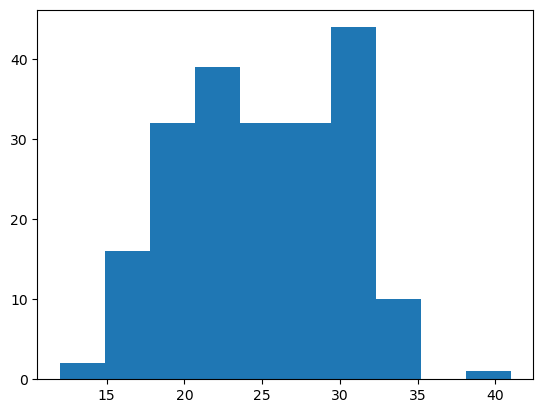

In [57]:
plt.hist(df_ratings_all.Seat_angle);

In [58]:
fig = px.box(df_ratings_all,  y= 'Seat_angle', notched = True,  )
             #color = 'Weight_status')
# Setting boxmean="sd" displays both the mean (dashed line) and standard deviation (filled area)
fig.update_traces(
    marker_line_color="black", # Sets the color of the lines bounding the box
    boxmean="sd",              # Sets the mean marker to a standard deviation shape
    selector=dict(type='box')
)

fig.update_layout(width=300, height=500, yaxis_title = 'Seat angle for 208 subjects')
fig.show();

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     4.944
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0273
Time:                        13:57:54   Log-Likelihood:                 34.915
No. Observations:                 208   AIC:                            -65.83
Df Residuals:                     206   BIC:                            -59.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.067      0.480      0.632      -0.100       0.164
x1             0.0058      0.003      2.223      0.027       0.001       0.011
==============================================================================
Omnibus:                       38.370   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.137
Skew:                           1.113   Prob(JB):                     1.76e-12
Kurtosis:                       4.137   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

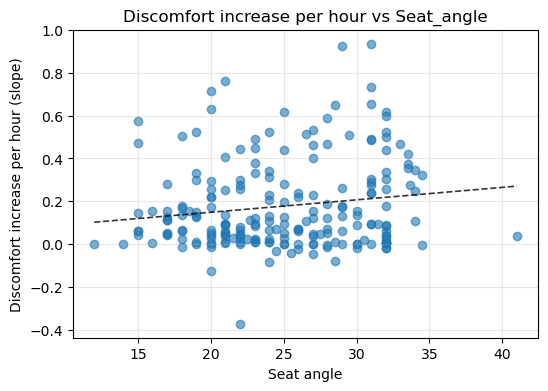

In [59]:
# Create combined figure
fig, axes = plt.subplots(figsize=(6,4))
scatter_ax(axes, df_ratings_all["Seat_angle"], df_ratings_all["slope_hour"], "Seat angle", "Discomfort increase per hour vs Seat_angle")
######### Seat angle is significant (p-value = 0.027) at 5% but not at 1% significance level

## Updated Regression Runs (Workbook Seat Angles)

This section uses seat angles from `Seat Study 1 - Completed Subjects Data.xlsx` (`BodyData-Timings` -> `Chosen Angle`).

Two runs are reported:
- `n = 168`: excluding the 40 participants who changed seat angle by >2 degrees (including text-note changes).
- `n = 208`: full analysis cohort.


In [60]:
# Build analysis dataframe using workbook seat angles
wb = pd.read_excel(Path(path) / 'Seat Study 1 - Completed Subjects Data.xlsx',
                   sheet_name='BodyData-Timings', header=1)

df_base = pd.read_csv(Path(path) / 'df_ratings_all.csv')[['subject', 'slope_hour']].copy()
df_base['slope_hour'] = df_base['slope_hour'] / 10

wb_angle = wb[['Subject', 'Chosen Angle', 'First Break Recorded Angle', 'Second Break Recorded Angle']].copy()
wb_angle.columns = ['subject', 'Seat_angle_raw', 'FirstBreak_raw', 'SecondBreak_raw']
wb_angle['subject'] = wb_angle['subject'].astype(str).str.strip()

df_workbook = df_base.merge(wb_angle, on='subject', how='left')

def parse_seat_angle(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace('?', '-').replace('?', '-')
    if s in ['', 'nan', 'N/A', 'None', 'none', 'na']:
        return np.nan
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    vals = [float(v) for v in nums]
    return float(np.mean(vals))

df_workbook['Seat_angle'] = df_workbook['Seat_angle_raw'].apply(parse_seat_angle)

for c in ['Seat_angle_raw', 'FirstBreak_raw', 'SecondBreak_raw']:
    df_workbook[c + '_num'] = pd.to_numeric(df_workbook[c], errors='coerce')

chg1 = (df_workbook['FirstBreak_raw_num'] - df_workbook['Seat_angle_raw_num']).abs()
chg2 = (df_workbook['SecondBreak_raw_num'] - df_workbook['Seat_angle_raw_num']).abs()
max_change = pd.concat([chg1, chg2], axis=1).max(axis=1, skipna=True)

text_only_change = (
    df_workbook['FirstBreak_raw_num'].isna()
    & df_workbook['SecondBreak_raw_num'].isna()
    & (df_workbook['FirstBreak_raw'].notna() | df_workbook['SecondBreak_raw'].notna())
)

exclude_40 = set(df_workbook.loc[(max_change > 2) | text_only_change, 'subject'].astype(str))

df_208 = df_workbook[df_workbook['Seat_angle'].notna() & df_workbook['slope_hour'].notna()].copy()
df_168 = df_208[~df_208['subject'].isin(exclude_40)].copy()

print('n (full cohort):', len(df_208))
print('Excluded by seat-angle-change rule:', len(exclude_40))
print('n (after exclusion):', len(df_168))


n (full cohort): 208
Excluded by seat-angle-change rule: 40
n (after exclusion): 168


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.496
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0633
Time:                        13:57:54   Log-Likelihood:                 27.477
No. Observations:                 168   AIC:                            -50.95
Df Residuals:                     166   BIC:                            -44.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.076      0.485      0.628      -0.113       0.186
x1             0.0057      0.003      1.870      0.063      -0.000       0.012
==============================================================================
Omnibus:                       32.101   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.522
Skew:                           1.104   Prob(JB):                     2.15e-10
Kurtosis:                       4.218   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

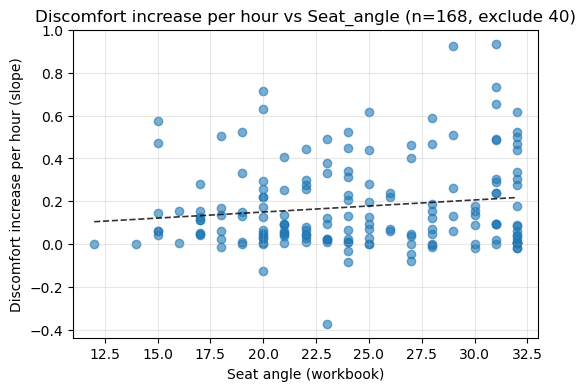

In [61]:
# Regression 1: Excluding 40 participants (n = 168)
fig, axes = plt.subplots(figsize=(6, 4))
scatter_ax(axes, df_168['Seat_angle'], df_168['slope_hour'],
           'Seat angle (workbook)',
           'Discomfort increase per hour vs Seat_angle (n=168, exclude 40)')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.767
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0172
Time:                        13:57:54   Log-Likelihood:                 35.320
No. Observations:                 208   AIC:                            -66.64
Df Residuals:                     206   BIC:                            -59.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.068      0.260      0.795      -0.116       0.152
x1             0.0065      0.003      2.401      0.017       0.001       0.012
==============================================================================
Omnibus:                       37.519   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.452
Skew:                           1.096   Prob(JB):                     4.08e-12
Kurtosis:                       4.115   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

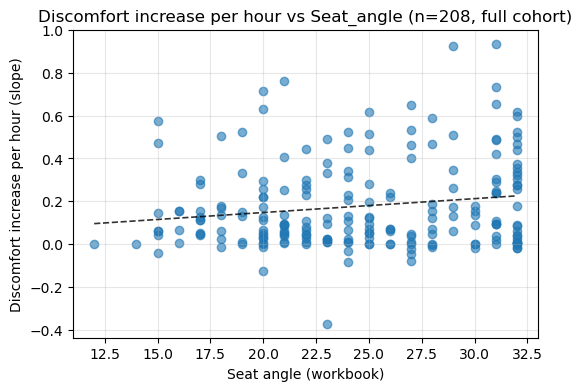

In [62]:
# Regression 2: Full cohort (n = 208)
fig, axes = plt.subplots(figsize=(6, 4))
scatter_ax(axes, df_208['Seat_angle'], df_208['slope_hour'],
           'Seat angle (workbook)',
           'Discomfort increase per hour vs Seat_angle (n=208, full cohort)')


## Additional Seat-Angle Analyses (n=168 vs n=208)

This mirrors the earlier descriptive analyses using workbook-based seat angles for both cohorts.


In [63]:
# Summary statistics
summary_df = pd.DataFrame({
    'cohort': ['n=168 (exclude 40)', 'n=208 (full)'],
    'n': [len(df_168), len(df_208)],
    'seat_angle_mean': [df_168['Seat_angle'].mean(), df_208['Seat_angle'].mean()],
    'seat_angle_sd': [df_168['Seat_angle'].std(), df_208['Seat_angle'].std()],
    'slope_hour_mean': [df_168['slope_hour'].mean(), df_208['slope_hour'].mean()],
    'slope_hour_sd': [df_168['slope_hour'].std(), df_208['slope_hour'].std()]
})
display(summary_df)


,cohort,n,seat_angle_mean,seat_angle_sd,slope_hour_mean,slope_hour_sd
0,n=168 (exclude 40),168,24.434524,5.289963,0.174786,0.208235
1,n=208 (full),208,24.639423,5.278686,0.177577,0.207520


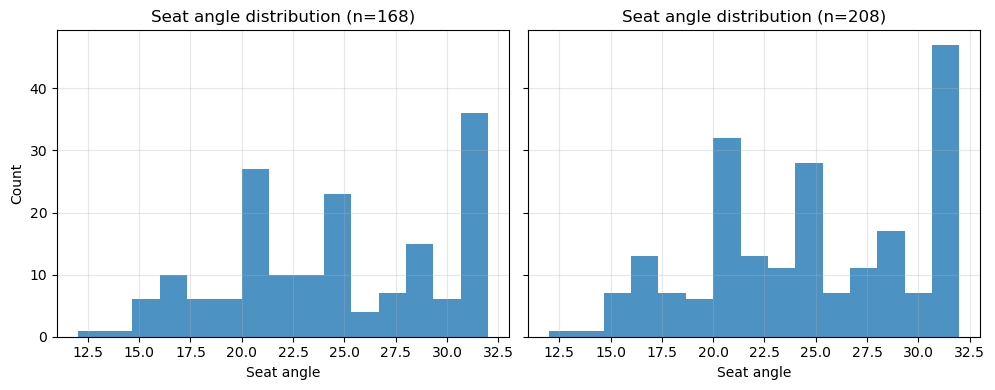

In [64]:
# Seat-angle distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(df_168['Seat_angle'], bins=15, alpha=0.8)
axes[0].set_title('Seat angle distribution (n=168)')
axes[0].set_xlabel('Seat angle')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_208['Seat_angle'], bins=15, alpha=0.8)
axes[1].set_title('Seat angle distribution (n=208)')
axes[1].set_xlabel('Seat angle')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()


In [65]:
# Box plots for direct comparison
box_df = pd.concat([
    df_168[['Seat_angle']].assign(cohort='n=168 (exclude 40)'),
    df_208[['Seat_angle']].assign(cohort='n=208 (full)')
])

fig = px.box(box_df, x='cohort', y='Seat_angle', notched=True, points='all')
fig.update_traces(marker_line_color='black', boxmean='sd', selector=dict(type='box'))
fig.update_layout(width=550, height=500, xaxis_title='Cohort', yaxis_title='Seat angle')
fig.show()


## Average Discomfort Regressions (n=208 and n=168)

Outcome: participant-level average discomfort rating (mean of `rating1` to `rating21`).
Predictor: workbook-based `Seat_angle`.


In [66]:
# Build participant-level average discomfort outcome
df_ratings_raw = pd.read_csv(Path(path) / 'df_ratings_all.csv')
rating_cols = [c for c in df_ratings_raw.columns if re.fullmatch(r'rating\d+', c)]
df_ratings_raw['avg_discomfort'] = df_ratings_raw[rating_cols].mean(axis=1, skipna=True)

# Reuse workbook-based seat angle and cohort definitions
df_avg = df_208[['subject', 'Seat_angle']].merge(
    df_ratings_raw[['subject', 'avg_discomfort']], on='subject', how='left'
)
df_avg_208 = df_avg[df_avg['Seat_angle'].notna() & df_avg['avg_discomfort'].notna()].copy()
df_avg_168 = df_avg_208[~df_avg_208['subject'].isin(exclude_40)].copy()

print('Average discomfort regression n (208):', len(df_avg_208))
print('Average discomfort regression n (168):', len(df_avg_168))


Average discomfort regression n (208): 208
Average discomfort regression n (168): 168


In [67]:
# Helper for generic OLS scatter plot
def scatter_ax_generic(ax, x, y, xlabel, ylabel, title):
    ax.scatter(x, y, alpha=0.6)
    X = sm.add_constant(np.asarray(x, float))
    model = sm.OLS(np.asarray(y, float), X).fit()
    display(model.summary())

    beta = model.params
    xx = np.linspace(min(x), max(x), 100)
    yy = beta[0] + beta[1] * xx
    ax.plot(xx, yy, '--', color='black', linewidth=1.2, alpha=0.8)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.415
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0368
Time:                        13:57:55   Log-Likelihood:                -757.41
No. Observations:                 208   AIC:                             1519.
Df Residuals:                     206   BIC:                             1525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8176      3.077      3.841      0.000       5.751      17.884
x1             0.2566      0.122      2.101      0.037       0.016       0.497
==============================================================================
Omnibus:                       95.507   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.237
Skew:                           1.937   Prob(JB):                     5.30e-72
Kurtosis:                       7.782   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

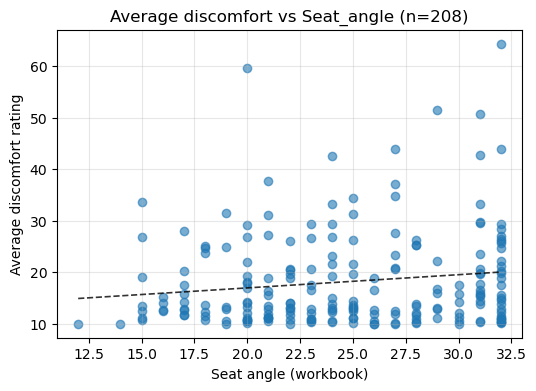

In [68]:
# Regression: avg discomfort vs seat angle (n=208 full cohort)
fig, axes = plt.subplots(figsize=(6, 4))
scatter_ax_generic(
    axes,
    df_avg_208['Seat_angle'],
    df_avg_208['avg_discomfort'],
    'Seat angle (workbook)',
    'Average discomfort rating',
    'Average discomfort vs Seat_angle (n=208)'
)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.725
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0553
Time:                        13:57:55   Log-Likelihood:                -619.43
No. Observations:                 168   AIC:                             1243.
Df Residuals:                     166   BIC:                             1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7356      3.554      3.302      0.001       4.718      18.753
x1             0.2744      0.142      1.930      0.055      -0.006       0.555
==============================================================================
Omnibus:                       76.804   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.600
Skew:                           1.893   Prob(JB):                     4.20e-52
Kurtosis:                       7.412   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

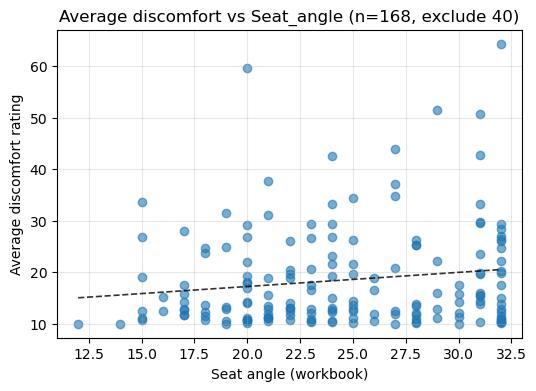

In [69]:
# Regression: avg discomfort vs seat angle (n=168 exclude 40)
fig, axes = plt.subplots(figsize=(6, 4))
scatter_ax_generic(
    axes,
    df_avg_168['Seat_angle'],
    df_avg_168['avg_discomfort'],
    'Seat angle (workbook)',
    'Average discomfort rating',
    'Average discomfort vs Seat_angle (n=168, exclude 40)'
)


## Seat Angle vs Discomfort Accumulation (n=152)

Subset definition: participants with statistically significant and positive discomfort accumulation slopes.


In [ ]:
# Build n=152 subset: Significant == True and slope_hour > 0
df_sig = pd.read_csv(Path(path) / 'df_ratings_all.csv')[['subject', 'Significant', 'slope_hour']].copy()
sig_mask = df_sig['Significant'].astype(str).str.strip().str.lower().isin({'true','1','yes','y','t'})
pos_mask = pd.to_numeric(df_sig['slope_hour'], errors='coerce') > 0

df_152 = df_208[['subject', 'Seat_angle', 'slope_hour']].merge(
    df_sig.loc[sig_mask & pos_mask, ['subject']], on='subject', how='inner'
)

print('n (significant + positive slope):', len(df_152))
display(df_152[['Seat_angle', 'slope_hour']].describe())


In [ ]:
# Regression: discomfort accumulation slope vs seat angle (n=152)
fig, axes = plt.subplots(figsize=(6, 4))
scatter_ax(
    axes,
    df_152['Seat_angle'],
    df_152['slope_hour'],
    'Seat angle (workbook)',
    'Discomfort increase per hour vs Seat_angle (n=152)'
)


## Additional Seat-Angle Analyses (n=152)

This mirrors the earlier descriptive plots for the significant+positive slope subset.


In [ ]:
# Summary statistics for n=152
summary_152 = pd.DataFrame({
    'cohort': ['n=152 (significant + positive slope)'],
    'n': [len(df_152)],
    'seat_angle_mean': [df_152['Seat_angle'].mean()],
    'seat_angle_sd': [df_152['Seat_angle'].std()],
    'slope_hour_mean': [df_152['slope_hour'].mean()],
    'slope_hour_sd': [df_152['slope_hour'].std()]
})
display(summary_152)


In [ ]:
# Seat-angle distribution for n=152
fig, axes = plt.subplots(figsize=(5, 4))
axes.hist(df_152['Seat_angle'], bins=15, alpha=0.8)
axes.set_title('Seat angle distribution (n=152)')
axes.set_xlabel('Seat angle')
axes.set_ylabel('Count')
axes.grid(True, alpha=0.3)
plt.tight_layout()


In [ ]:
# Box plot for n=152
fig = px.box(df_152, y='Seat_angle', notched=True, points='all')
fig.update_traces(marker_line_color='black', boxmean='sd', selector=dict(type='box'))
fig.update_layout(width=320, height=500, yaxis_title='Seat angle for 152 subjects')
fig.show()
